# Libraries

In [1]:
import sys
sys.path.insert(1, '../library')
import New_ESN
import helpers
from sklearn.model_selection import TimeSeriesSplit
import yfinance as yf
import numpy as np
import pandas as pd

# Raw Data

In [2]:
petra = yf.Ticker('PBR')
petra_historical = petra.history(period="max", interval="1wk")
petra_historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-08-07 00:00:00-04:00,1.818994,2.098146,1.764964,2.057624,169068400,0.0,0.0
2000-08-14 00:00:00-04:00,2.026106,2.242224,2.017102,2.089141,43714800,0.0,0.0
2000-08-21 00:00:00-04:00,2.089140,2.179189,2.044115,2.179189,26162400,0.0,0.0
2000-08-28 00:00:00-04:00,2.188195,2.377298,2.147672,2.246727,27338400,0.0,0.0
2000-09-04 00:00:00-04:00,2.237721,2.453839,2.219712,2.359288,20408000,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-23 00:00:00-05:00,11.570000,14.460000,9.630000,11.290000,115001400,0.0,0.0
2023-01-30 00:00:00-05:00,11.490000,11.770000,10.730000,10.840000,125902700,0.0,0.0
2023-02-06 00:00:00-05:00,10.840000,11.570000,10.710000,11.530000,136987100,0.0,0.0


# Split data into train and test

In [17]:
date_year = pd.to_datetime(petra_historical.index).date
percentage_split = 0.2
a = int(np.round(len(petra_historical)*percentage_split))


X = petra_historical[['Open','High','Low', 'Close']][:a]
y = petra_historical['Close'][:a]

X_test = petra_historical[['Open','High','Low', 'Close']][a:-1]
y_test = petra_historical['Close'][a+1:]

# Params

In [4]:
number_of_trains = 100
size_input = X.shape[1]
size_output = 1
size_reservoir = 200

# Split train data into train and validation

In [5]:
tss = TimeSeriesSplit(n_splits = number_of_trains, test_size=size_output)
X_train = []
y_train = []

for i, (train_index, label_index) in enumerate(tss.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Label:  index={label_index}")
    X_train.append(X.iloc[train_index, :])
    index = np.concatenate([train_index[1:],label_index])
    y_train.append(y.iloc[index])

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134]
  Label:  index=[135]
Fold 1:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  

# Iniciating class ESN

In [6]:
esn = New_ESN.ESN(
                input_scaling = 1,
                epochs = 2,
                N_u = size_input,
                N_y = size_output,
                N_r = size_reservoir,
                sparsity = 0.4,
                alpha = 0.1, 
                beta = 0.5, 
                verbose = True, 
                method = 'ridge_regression',
                TF = True    
                )

W_reservoir.shape:  (200, 200)
W_in.shape:  (200, 4)
W_feedb.shape (200, 1)
W_out.shape:  (1, 205)


# Training

In [7]:
for i,j in zip(X_train,y_train):
    esn.fit(np.array(i),np.array(j))

# Predicting

In [24]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [20]:
X_test.shape, y_test.shape

((941, 4), (941,))

In [26]:
results = []
#results.append(esn.predict(X_test[0][np.newaxis,:],y_test[0][np.newaxis,np.newaxis]))
for i,j in zip(X_test[-1],y_test[]):
    results.append(esn.predict(i[np.newaxis,:],j[np.newaxis,np.newaxis]))

Prediction 0: 4.10390411430304
Prediction 0: 4.167081936536405
Prediction 0: 4.480931956317189
Prediction 0: 4.463117970533076
Prediction 0: 4.220969814747466
Prediction 0: 4.086969722532132
Prediction 0: 3.9575787828267557
Prediction 0: 4.048553208677217
Prediction 0: 4.094602767641387
Prediction 0: 3.838220371022791
Prediction 0: 3.8770701674643377
Prediction 0: 3.8691660048957397
Prediction 0: 4.068497281486168
Prediction 0: 3.9096538020902742
Prediction 0: 4.0743302366899945
Prediction 0: 4.25096312157485
Prediction 0: 4.372917670987633
Prediction 0: 4.2861956118604505
Prediction 0: 4.5470194058461955
Prediction 0: 4.624712169406541
Prediction 0: 4.701108275476141
Prediction 0: 4.8424838414898215
Prediction 0: 4.730565816441923
Prediction 0: 4.737436054799563
Prediction 0: 4.775515156108637
Prediction 0: 5.102847984315764
Prediction 0: 5.405000911086552
Prediction 0: 5.1969249480151145
Prediction 0: 5.2691028954599695
Prediction 0: 5.595071067326206
Prediction 0: 5.947435611024471


In [27]:
import matplotlib.pyplot as plt

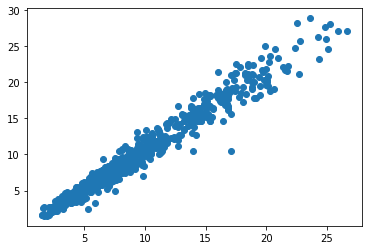

In [13]:
plt.scatter(np.squeeze(results), y_test[1:])
plt.show()

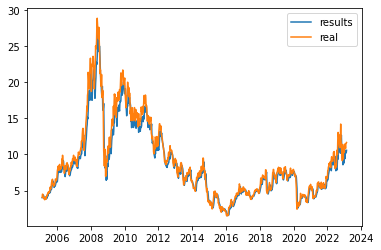

In [16]:
plt.plot(date_year[-941:],np.squeeze(results)[:-2], label = 'results')
plt.plot(date_year[-941:],y_test[1:], label = 'real')
plt.legend()
plt.show()